<a href="https://colab.research.google.com/github/rhilderbrand/MSDS-422-MachineLearning/blob/main/Hilderbrand_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 3: Evaluating Classification Models

In [56]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [57]:
# import base packages into the namespace for this program
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# output of plotting commands is displayed inline directly below the code cell that produced it
%matplotlib inline

In [59]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

In [60]:
#S2 Mount Google Drive to Colab Enviorment
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [61]:
#S3 Establish working directory
import os # Operation System
os.getcwd()
%cd /content/gdrive/My Drive/Colab Notebooks/Week 3/
!pwd
!ls
print('Working Directory')
print(os.getcwd())

/content/gdrive/My Drive/Colab Notebooks/Week 3
/content/gdrive/My Drive/Colab Notebooks/Week 3
bank.csv	Hilderbrand_Assignment_3  plot-corr-map.pdf
cv-results.txt	Log_ROC.png		  PML_Assignment3_GettingStarted.ipynb
Working Directory
/content/gdrive/My Drive/Colab Notebooks/Week 3


In [62]:
# Load data
work_dir = " /content/gdrive/My Drive/Colab Notebooks/Week 3/"
bank = pd.read_csv('bank.csv', sep=';')

##Exploratory Data Analysis

**Data Dictionary**

**age** - age in years

**job** - type of job (admin, unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, services)

**education** - Level of eduction (unknown, secondary, primary, tertiary)

**default** - has credit in default? (yes, no)

**balance** - average yearly balance (in euros)

**housing** - has housing loan? (yes, no)

**loan** - has personal loan? (yes, no)

**contact** - contact communication type (unknown, telephone, cellular)

**day** - last contact day of the month

**month** - last contact month of year

**duration** - last contact duration (in seconds)

**campaign** - number of contacts performed during this campaign for this client (includes last contact)

**pdays** - Number of days that passed since the client was last contacted from a previous campaign (-1 means client was not previously contacted)

**previous** - number of contacts performed before this campaign for this client

**poutcome** - outcome of previous marketing campaighn (unknown, other, failure, success)

**response** - response to most recent marketing contact/call has the client subscribed to a term deposit? (yes, no)

In [63]:
# print first and last five rows of the df
bank.head()
bank.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [64]:
# Look at df general info
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  response   4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [65]:
# examine the shape of original input data
print(bank.shape)

(4521, 17)


We see from the data frame info that there doesn't seem to be any missing or null values for any features, but we double check for null values using isnull() and confirm there aren't any null values.

In [66]:
# check for any null values
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
response     0
dtype: int64

Looking at the list of columns allows us to look at the features. We determine that the 'response' column is our target variable.

In [67]:
# look at the list of column names
list(bank.columns.values)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

In [68]:
# Descriptive Statistics for non-categorical variables
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


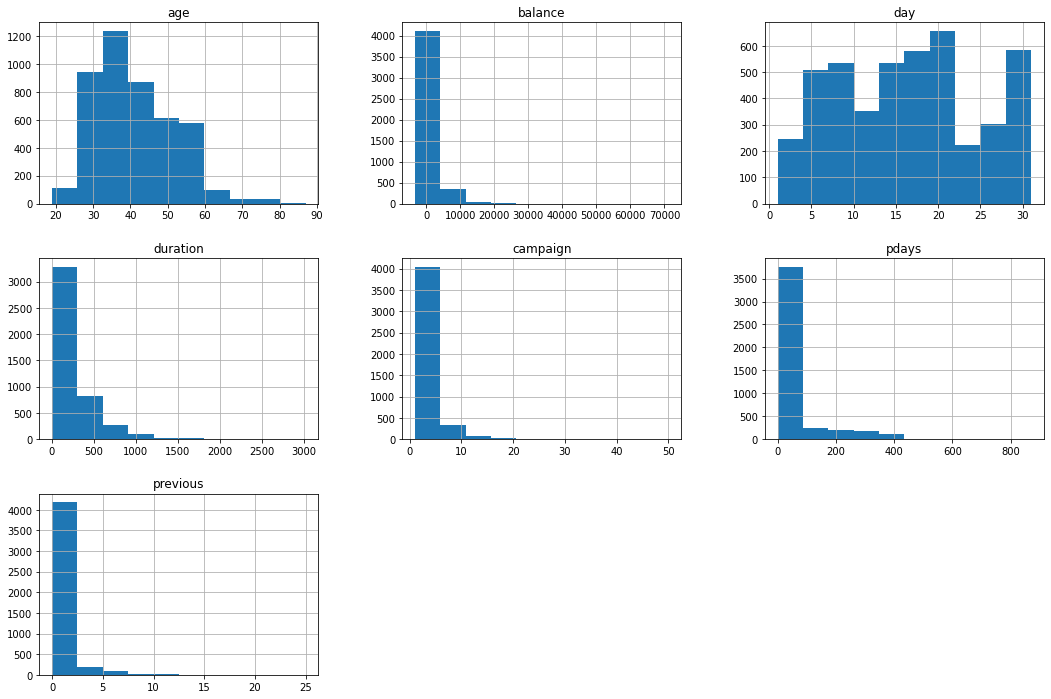

In [69]:
# Check distributions of non-categorical variables
bank.hist(figsize=(18,12));

In [70]:
bank['response'].value_counts()

no     4000
yes     521
Name: response, dtype: int64

<Figure size 432x288 with 0 Axes>

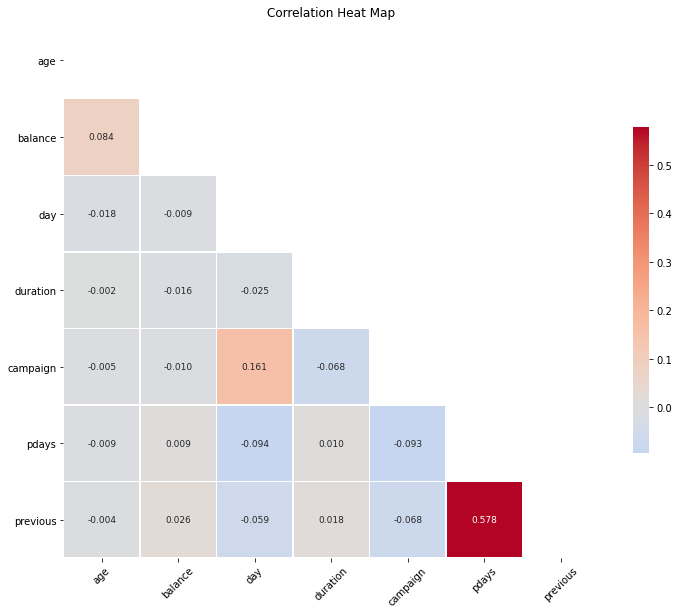

In [71]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

# examine correlations
corr_chart(df_corr = bank) 

In [72]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(default), np.array(housing), np.array(loan), 
    np.array(response)]).T

# examine the shape of model_data, which we will use in subsequent modeling
print(model_data.shape)

(4521, 4)


In [73]:
# Check the frequency of "default", "loan", "housing" by "response"
(pd.crosstab([bank['default'],bank['loan'],bank['housing']], [bank['response']], margins=True))

# pd.crosstab([bank['default'],bank['loan'],bank['housing']],columns=bank['response'])

# # Check the frequency of "default", "loan", "housing" by "response"
# print(pd.crosstab([bank['default'],bank['loan'],bank['housing']], [bank['response']], margins=True))

response                no  yes   All
default loan housing                 
no      no   no       1381  279  1660
             yes      1927  192  2119
        yes  no        255   16   271
             yes       370   25   395
yes     no   no         13    4    17
             yes        31    3    34
        yes  no         12    2    14
             yes        11    0    11
All                   4000  521  4521

In [74]:
ct = (pd.crosstab([bank['default'],bank['loan'],bank['housing']], 
                  [bank['response']], margins=True))
ct_nm = (pd.crosstab([bank['default'],bank['loan'],bank['housing']], 
                  [bank['response']], margins=False))
ct2 = pd.crosstab(bank.response,bank.default)
ct3 = pd.crosstab(bank.response,bank.loan)
ct4 = pd.crosstab(bank.response,bank.housing)

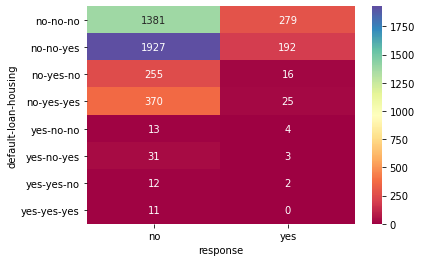

<Figure size 432x288 with 0 Axes>

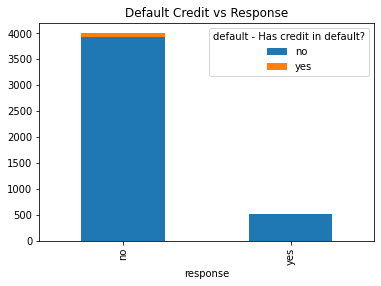

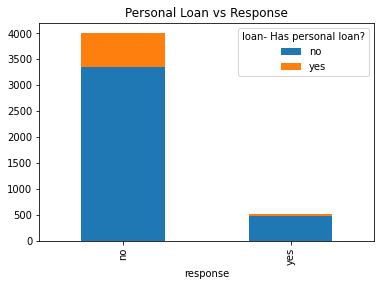

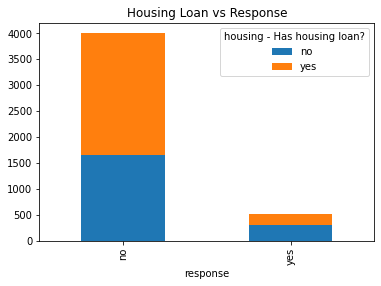

In [75]:
plt.figure()
sns.heatmap(ct_nm,cmap="Spectral", annot=True, cbar=True,fmt='g');

plt.figure()
ct2.plot.bar(stacked=True)
plt.legend(title='default - Has credit in default?')
plt.title("Default Credit vs Response")
plt.show();

ct3.plot.bar(stacked=True)
plt.legend(title='loan- Has personal loan?')
plt.title("Personal Loan vs Response")
plt.show();

ct4.plot.bar(stacked=True)
plt.legend(title='housing - Has housing loan?')
plt.title("Housing Loan vs Response")
plt.show();

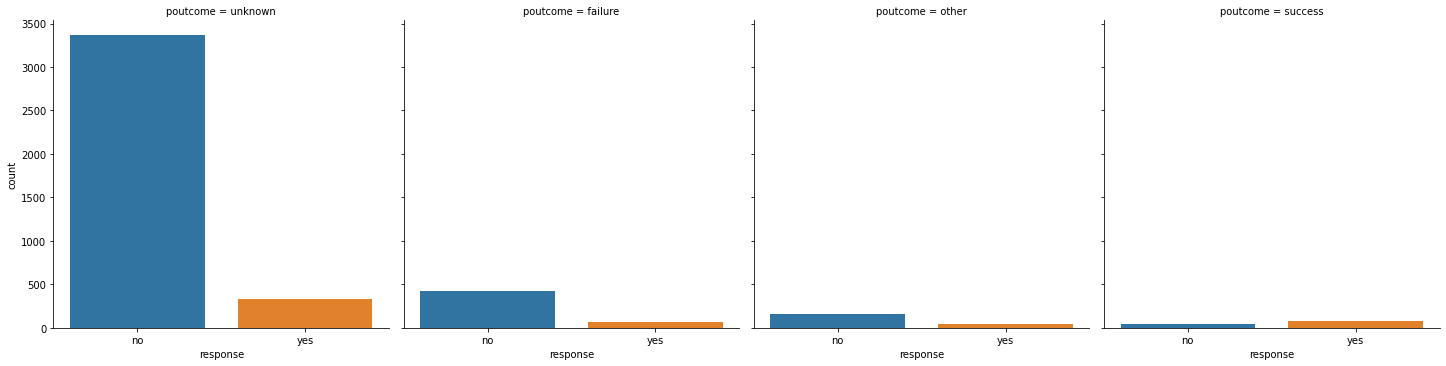

In [76]:
sns.catplot(x="response", col="poutcome", data=bank, kind="count")

In [77]:
# shuffle is by the first index, which is the rows
np.random.seed(RANDOM_SEED)
np.random.shuffle(model_data)

# dimensions of the additive model X input and y response
print('\nData dimensions:', model_data.shape)

# --------------------------------------------------------


Data dimensions: (4521, 4)


In [78]:
# Prepare Data for Model
model_data = np.array( [ np.array(default), np.array(housing), np.array(loan), np.array(response)]).T

In [79]:
# Ensure we have the same number of observations.
assert len(bank) == len(model_data)

In [80]:
model_data.shape

(4521, 4)

## Classification Models

In [81]:
# determine features and target variable
model_data = pd.DataFrame(model_data, columns=['default','loan','housing','response'])
X = model_data.drop(['response'], axis=1)
y = model_data.drop(['default','loan','housing'], axis=1)

# dimensions of the additive model X input and y response
print('\nData dimensions:', model_data.shape)


Data dimensions: (4521, 4)


In [82]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   default   4521 non-null   int64
 1   loan      4521 non-null   int64
 2   housing   4521 non-null   int64
 3   response  4521 non-null   int64
dtypes: int64(4)
memory usage: 141.4 KB


In [83]:
# import sklearn metrics for ROC curve and score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [84]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

y_pred_prob = logreg.predict_proba(X_test)[:,1]

In [85]:
# create a function to plot ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

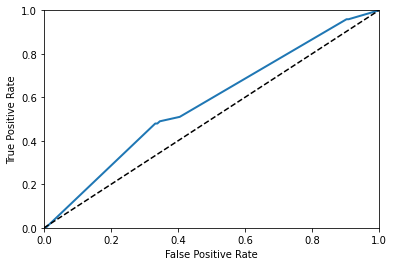

In [86]:
# plot logreg ROC curve and print ROC AUC score
roc_auc_score(y_test,y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plot_roc_curve(fpr, tpr)
plt.show()

In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(y_test, y_pred))

[[807   0]
 [ 98   0]]


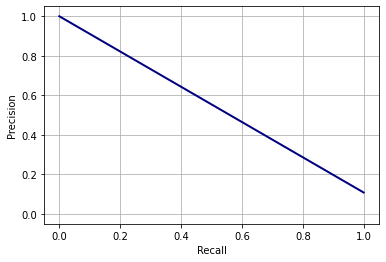

In [88]:
from sklearn.metrics import precision_recall_curve

y_score = logreg.fit(X_train, y_train).decision_function(X_train)
y_pred = logreg.fit(X_train, y_train).predict(X_test)

precision, recall, threshold = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, lw=2, color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.grid()

In [89]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
y_pred_prob_nb = nb.predict_proba(X_test)[:,1]

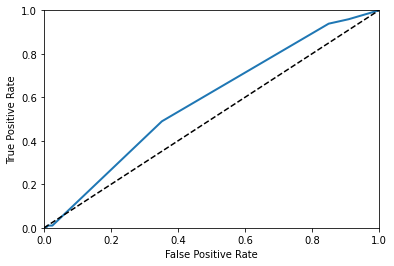

In [90]:
# plot nb ROC curve and print ROC AUC score
roc_auc_score(y_test,y_pred_prob_nb)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_nb)
plot_roc_curve(fpr, tpr)
plt.show()

In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(y_test, y_pred_nb))

[[787  20]
 [ 97   1]]


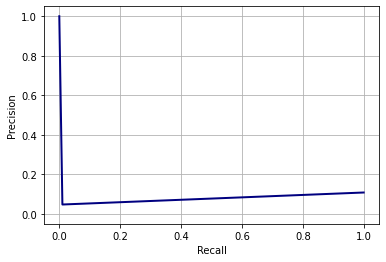

In [92]:
from sklearn.metrics import precision_recall_curve

y_score = logreg.fit(X_train, y_train).decision_function(X_train)
y_pred = logreg.fit(X_train, y_train).predict(X_test)

precision, recall, threshold = precision_recall_curve(y_test, y_pred_nb)

plt.plot(recall, precision, lw=2, color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.grid()

## Cross Validation

In [93]:
# specify classification models and names
names = ["Naive_Bayes","Logistic_Regression"]
classifiers = [GaussianNB(), LogisticRegression(solver='lbfgs')]
model_data = np.array( [ np.array(default), np.array(housing), np.array(loan), np.array(response)]).T


Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4068, 3)
X_test: (453, 3)
y_train: (4068,)
y_test: (453,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.589491405280879


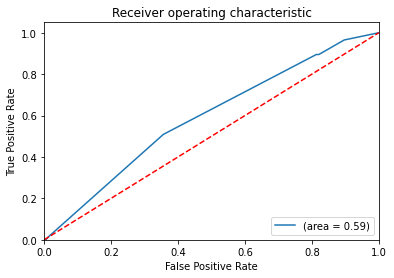


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5878522062732588


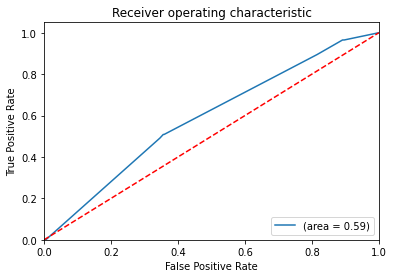


Fold index: 1 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.6169147569072607


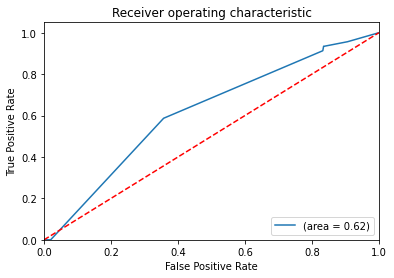


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.633727778967659


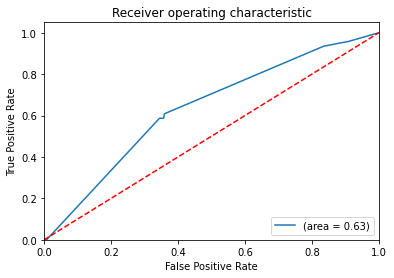


Fold index: 2 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.6518029056537721


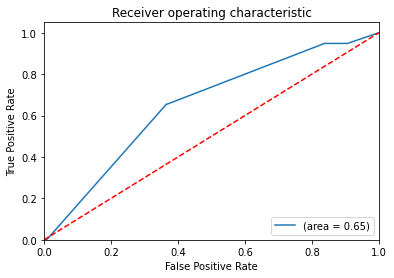


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.6575354454752319


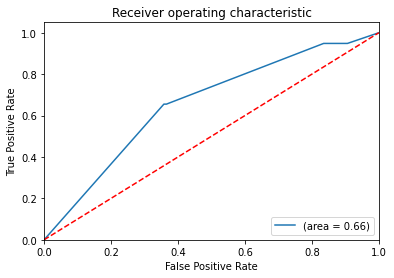


Fold index: 3 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.6343495214462956


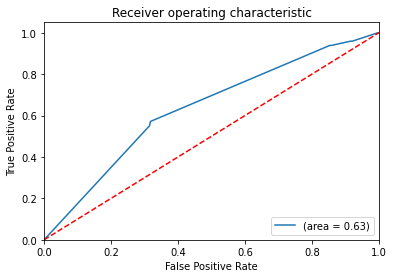


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.6355648959335594


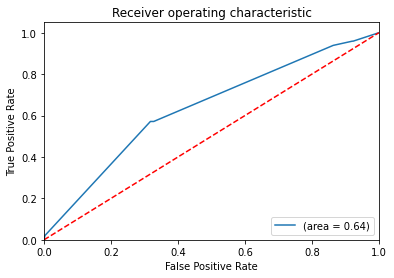


Fold index: 4 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.5698712842228837


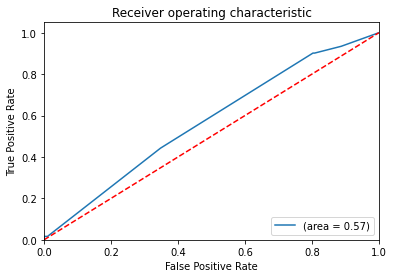


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5743993962517295


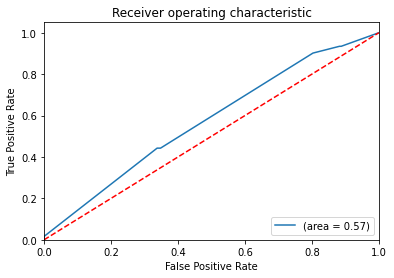


Fold index: 5 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.575752180879473


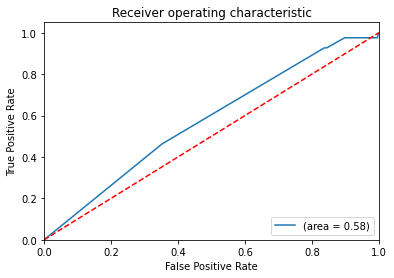


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5842383241350662


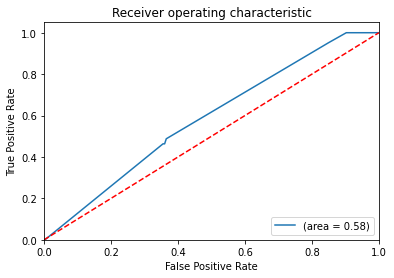


Fold index: 6 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.5573003908431043


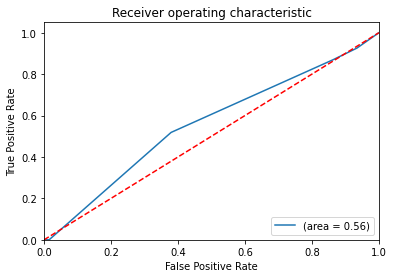


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5625116322352502


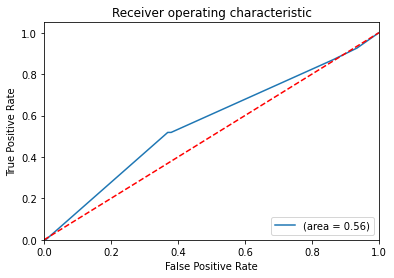


Fold index: 7 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.7278019162210339


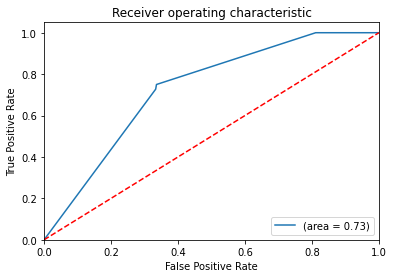


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.7311441622103387


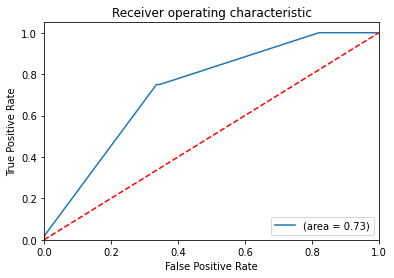


Fold index: 8 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.557407670118693


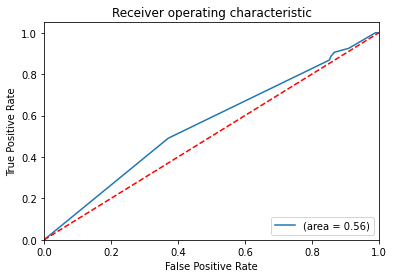


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5735328888258382


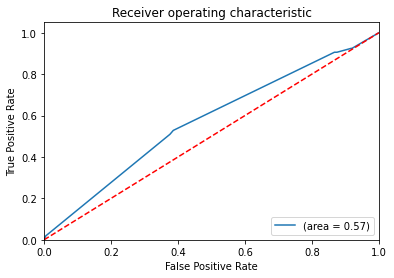


Fold index: 9 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: GaussianNB(priors=None, var_smoothing=1e-09)
Area under ROC curve: 0.5778268860493612


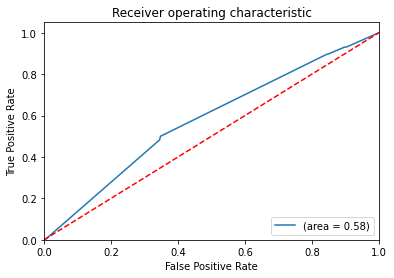


Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Area under ROC curve: 0.5768204095921582


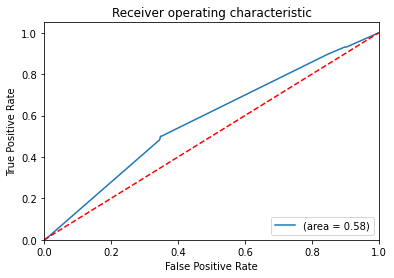


----------------------------------------------
Average results from 10-fold cross-validation

Method                 Area under ROC Curve
Naive_Bayes            0.605852
Logistic_Regression    0.611733
dtype: float64


In [94]:
# specify the k-fold cross-validation design
from sklearn.model_selection import KFold

# ten-fold cross-validation employed here
N_FOLDS = 10

# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized

for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   note that 0:model_data.shape[1]-1 slices for explanatory variables
#   and model_data.shape[1]-1 is the index for the response variable    
    X_train = model_data[train_index, 0:model_data.shape[1]-1]
    X_test = model_data[test_index, 0:model_data.shape[1]-1]
    y_train = model_data[train_index, model_data.shape[1]-1]
    y_test = model_data[test_index, model_data.shape[1]-1]   

    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        print('\nClassifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        # evaluate on the test set for this fold
        y_test_predict = clf.predict_proba(X_test)
        fold_method_result = roc_auc_score(y_test, y_test_predict[:,1]) 
        print('Area under ROC curve:', fold_method_result)
        cv_results[index_for_fold, index_for_method] = fold_method_result
  
        logit_roc_auc = roc_auc_score(y_test, y_test_predict[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, y_test_predict[:,1])
        plt.figure()
        plt.plot(fpr, tpr, label='(area = %0.2f)' % logit_roc_auc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()
        index_for_method += 1

    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      '\nMethod                 Area under ROC Curve', sep = '')     
print(cv_results_df.mean())

## Summary

In [97]:
# Save the cross-validation results.
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names
with open("cv-results.txt", "w") as text_file:
    text_file.write('\nResults from '+ str(N_FOLDS) + '-fold cross-validation\n'+
                     '\nMethod Area under ROC Curve:\n'+ 
                     str(cv_results_df))

In [98]:
pd.options.display.float_format = '{:,.6f}'.format
cv_results_df.mean() # same as the results in the display above

Naive_Bayes           0.605852
Logistic_Regression   0.611733
dtype: float64